In [1]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Загрузка и предобработка данных

In [3]:
(X_train, _), (_, _) = mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_train_p = (X_train.astype(np.float32) - 127.5) / 127.5
X_train_p = X_train_p.reshape(X_train.shape[0], -1)
X_train_p.shape, np.max(X_train_p), np.min(X_train_p)

((60000, 784), 1.0, -1.0)

# Постройка модели

In [6]:
RANDOM_SIZE = 100
IMG_SIZE = 784

In [7]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [8]:
generator = Sequential()
generator.add(L.Dense(256, input_dim=RANDOM_SIZE))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Dense(512))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Dense(1024))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [9]:
discriminator = Sequential()
discriminator.add(L.Dense(1024, input_dim=IMG_SIZE))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Dense(512))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Dense(256))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [10]:
discriminator.trainable = False
ganInput = L.Input(shape=(RANDOM_SIZE,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)

In [11]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [12]:
def train(epochs=1, batch_size=128):
 
  batchCount = int(X_train_p.shape[0] / batch_size)

  for epoch in range(1, epochs+1):
    print("-"*10, "Epoch: {}".format(epoch), "-"*10)

    for _ in range(batchCount):
      # обучение дискриминатора
      idxs = np.random.choice(len(X_train_p), size=batch_size, replace=False)
      fake = generator.predict(np.random.normal(0, 1, size=(batch_size, RANDOM_SIZE)))
      labels = np.r_[np.ones(shape=batch_size)*0.95, np.zeros(shape=batch_size)]
      X = np.r_[X_train_p[idxs], fake]
      discriminator.trainable = True
      dloss = discriminator.train_on_batch(X, labels)

      # обучение генератора
      labels = np.ones(shape=batch_size)
      X = np.random.normal(0, 1, size=(batch_size, RANDOM_SIZE))
      discriminator.trainable = False
      gloss = gan.train_on_batch(X, labels)

    # оценка ошибок и периодическое сохранение картинок
    gLoss.append(gloss)
    dLoss.append(dloss)

    if epoch % 4 == 0:
      print("Эпоха {}".format(epoch))
      print("gloss {}, dloss {}".format(gloss, dloss))
      noise = np.random.normal(0, 1, size=(1, RANDOM_SIZE))
      imgs = generator.predict(noise)      
      plt.imshow(imgs.reshape(28,28))
      plt.savefig("./img-{}".format(epoch))
      discriminator.save("./discriminator.h5")
      generator.save("./generator.h5")

In [13]:
generator.load_weights("./generator-epoch-90.h5")
discriminator.load_weights("./discriminator-epoch-90.h5")

---------- Epoch: 1 ----------
---------- Epoch: 2 ----------
---------- Epoch: 3 ----------
---------- Epoch: 4 ----------
Эпоха 4
gloss 1.0471837520599365, dloss 0.6162290573120117
---------- Epoch: 5 ----------
---------- Epoch: 6 ----------
---------- Epoch: 7 ----------
---------- Epoch: 8 ----------
Эпоха 8
gloss 0.8099971413612366, dloss 0.6443167924880981
---------- Epoch: 9 ----------
---------- Epoch: 10 ----------
---------- Epoch: 11 ----------
---------- Epoch: 12 ----------
Эпоха 12
gloss 0.8853727579116821, dloss 0.641223669052124
---------- Epoch: 13 ----------
---------- Epoch: 14 ----------
---------- Epoch: 15 ----------
---------- Epoch: 16 ----------
Эпоха 16
gloss 0.9881061315536499, dloss 0.6627048254013062
---------- Epoch: 17 ----------
---------- Epoch: 18 ----------
---------- Epoch: 19 ----------
---------- Epoch: 20 ----------
Эпоха 20
gloss 1.023375391960144, dloss 0.6322528123855591


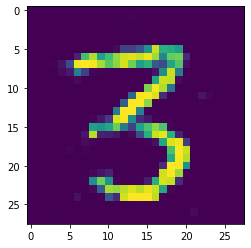

In [14]:
dLoss = []
gLoss = []
train(20, 128)

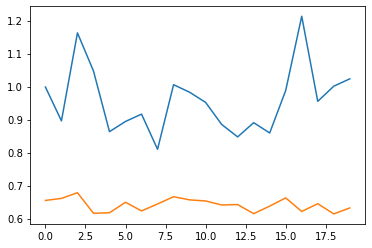

In [15]:
plt.plot(gLoss, label="generator loss")
plt.plot(dLoss, label="discriminator loss")
plt.show()

In [16]:
!ls *epoch*

discriminator-epoch-10.h5  discriminator-epoch-60.h5  generator-epoch-40.h5
discriminator-epoch-15.h5  discriminator-epoch-65.h5  generator-epoch-45.h5
discriminator-epoch-1.h5   discriminator-epoch-70.h5  generator-epoch-50.h5
discriminator-epoch-20.h5  discriminator-epoch-80.h5  generator-epoch-55.h5
discriminator-epoch-25.h5  discriminator-epoch-90.h5  generator-epoch-5.h5
discriminator-epoch-30.h5  generator-epoch-10.h5      generator-epoch-60.h5
discriminator-epoch-35.h5  generator-epoch-15.h5      generator-epoch-65.h5
discriminator-epoch-40.h5  generator-epoch-1.h5       generator-epoch-70.h5
discriminator-epoch-45.h5  generator-epoch-20.h5      generator-epoch-80.h5
discriminator-epoch-50.h5  generator-epoch-25.h5      generator-epoch-90.h5
discriminator-epoch-55.h5  generator-epoch-30.h5
discriminator-epoch-5.h5   generator-epoch-35.h5


### Анализ полученных результатов

In [17]:
generator.load_weights("./generator-epoch-90.h5")

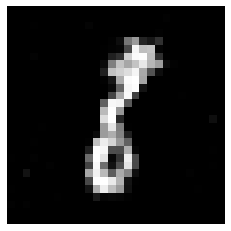

In [18]:
result = generator.predict(np.random.normal(0,1, size=(1,RANDOM_SIZE)))
plt.imshow(result.reshape(28,28), cmap='gray')
plt.axis("off")
plt.show()

# Генерация временных рядов

In [19]:
RANDOM_SIZE = 128

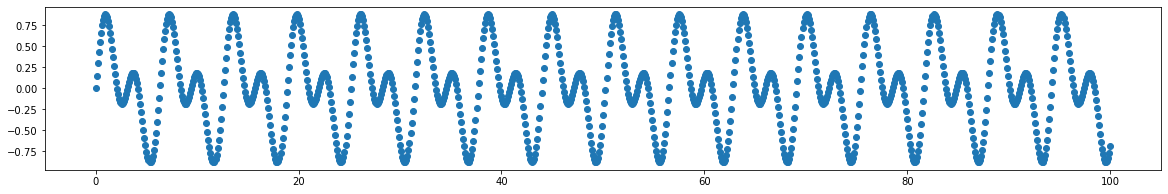

In [20]:
xs = np.linspace(0, 100, 1000)
ys = 0.5*np.sin(xs) + 0.5*np.sin(2*xs)

plt.figure(figsize=(20,3))
plt.scatter(xs, ys)
plt.show()

In [21]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [22]:
g_ = Sequential()
g_.add(L.Dense(256, input_dim=RANDOM_SIZE))
g_.add(L.LeakyReLU(0.2))
g_.add(L.Dense(512))
g_.add(L.LeakyReLU(0.2))
g_.add(L.Dense(1024))
g_.add(L.LeakyReLU(0.2))
g_.add(L.Dense(128, activation='tanh'))
g_.compile(loss='binary_crossentropy', optimizer=adam)

In [23]:
d_ = Sequential()
d_.add(L.Dense(1024, input_dim=128))
d_.add(L.LeakyReLU(0.2))
d_.add(L.Dropout(0.3))
d_.add(L.Dense(512))
d_.add(L.LeakyReLU(0.2))
d_.add(L.Dropout(0.3))
d_.add(L.Dense(256))
d_.add(L.LeakyReLU(0.2))
d_.add(L.Dropout(0.3))
d_.add(L.Dense(1, activation='sigmoid'))
d_.compile(loss='binary_crossentropy', optimizer=adam)

In [24]:
d_.trainable = False
ganInput = L.Input(shape=(RANDOM_SIZE,))
x = g_(ganInput)
ganOutput = d_(x)
gan = Model(inputs=ganInput, outputs=ganOutput)

In [25]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [54]:
def train(data, epochs=100, batch_size=128):
 
    batchCount = int(data.shape[0] / batch_size)    
    for epoch in range(1, epochs+1):
        print("-"*10, "Epoch: {}".format(epoch), "-"*10)

        for _ in range(batchCount):
            # обучение дискриминатора
            idxs = np.random.choice(len(data)-128, size=batch_size, replace=False)
            fake = g_.predict(np.random.normal(0, 1, size=(batch_size, RANDOM_SIZE)))
            labels = np.r_[np.ones(shape=batch_size)*0.95, np.zeros(shape=batch_size)]
            X = np.r_[[data[idx:idx+128] for idx in idxs], fake]
            d_.trainable = True
            dloss = d_.train_on_batch(X, labels)
    
            # обучение генератора
            labels = np.ones(shape=batch_size)
            X = np.random.normal(0, 1, size=(batch_size, RANDOM_SIZE))
            d_.trainable = False
            gloss = gan.train_on_batch(X, labels)
    
            # оценка ошибок и периодическое сохранение картинок
            gLoss.append(gloss)
            dLoss.append(dloss)

        if epoch % 10 == 0:
            print("Эпоха {}".format(epoch))
            print("gloss {}, dloss {}".format(gloss, dloss))
            noise = np.random.normal(0, 1, size=(1, RANDOM_SIZE))
            imgs = g_.predict(noise)
            plt.plot(imgs)
            plt.savefig("./img-{}".format(epoch))
            discriminator.save("./discriminator.h5")
            generator.save("./generator.h5")
            

---------- Epoch: 1 ----------
---------- Epoch: 2 ----------
---------- Epoch: 3 ----------
---------- Epoch: 4 ----------
---------- Epoch: 5 ----------
---------- Epoch: 6 ----------
---------- Epoch: 7 ----------
---------- Epoch: 8 ----------
---------- Epoch: 9 ----------
---------- Epoch: 10 ----------
Эпоха 10
gloss 1.765181303024292, dloss 0.33900436758995056
---------- Epoch: 11 ----------
---------- Epoch: 12 ----------
---------- Epoch: 13 ----------
---------- Epoch: 14 ----------
---------- Epoch: 15 ----------
---------- Epoch: 16 ----------
---------- Epoch: 17 ----------
---------- Epoch: 18 ----------
---------- Epoch: 19 ----------
---------- Epoch: 20 ----------
Эпоха 20
gloss 1.4803638458251953, dloss 0.34783291816711426
---------- Epoch: 21 ----------
---------- Epoch: 22 ----------
---------- Epoch: 23 ----------
---------- Epoch: 24 ----------
---------- Epoch: 25 ----------
---------- Epoch: 26 ----------
---------- Epoch: 27 ----------
---------- Epoch: 28 ---

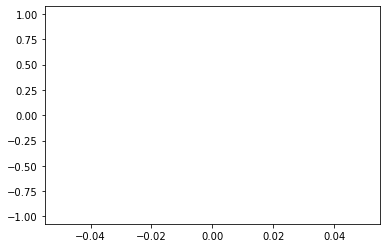

In [55]:
train(ys)

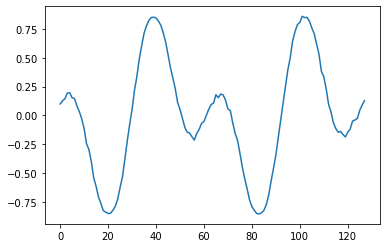

In [74]:
data = g_.predict(np.random.normal(0, 1, size=(2, RANDOM_SIZE)))
plt.plot(data[0])

# Возможные направления для самостоятельных исследований

- DCGAN
- DCGAN для фото знаменитостей
- Использование GAN для генерации текстов